In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utility
from get_data import get_structured_data
from classifiers import *
from constants import *
from island_week_data import TurnipPattern
import os.path
from functools import reduce

In [2]:
rows = get_structured_data()
populated_rows = [row for row in rows if row.has_patterns_populated()]

In [3]:
valid_X, valid_rows, valid_y = utility.get_all_data(populated_rows)
valid_X.shape, valid_y.shape

((71, 12), (71, 1))

In [4]:
perfect_X, perfect_rows, perfect_y = utility.get_perfect_data(populated_rows)
perfect_X.shape, perfect_y.shape

((25, 12), (25, 1))

In [5]:
def get_example_prices(data_x, data_y):
    all_values, indexes = np.unique(data_y, return_index=True)
    return data_x[indexes][-4:], data_y[indexes][-4:], indexes[-4:]

In [6]:
def get_pattern_names(data_patterns):
    output = []
    named_patterns = [(p.value[0], p.value[1]) for p in TurnipPattern][2:]
    for p in list(data_patterns):
        for name, val in named_patterns:
            if val == p:
                output.append(name)
    return output

In [7]:
def construct_graph_data(data_x, data_y):
    prices, raw_patterns, indexes = get_example_prices(data_x, data_y)
    named_patterns = get_pattern_names(raw_patterns)
    time_periods = np.asarray(list(range(12))).reshape(-1)
    return pd.DataFrame(data=prices, columns=time_periods, index=named_patterns), indexes

In [8]:
def graph_turnip_prices(data, keys, is_perfect=False):
    for k in keys:
        plt.title(f'{"Perfect " if is_perfect else ""}Turnip Pattern: {k}')
        sns.lineplot(x=data.columns, y=data.loc[k, :])
        plt.show()

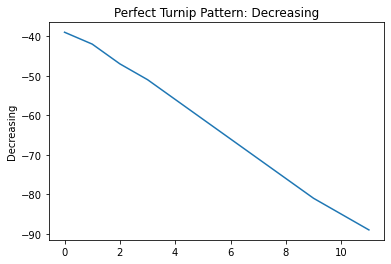

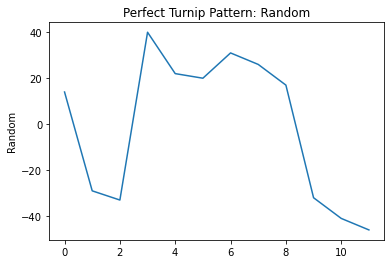

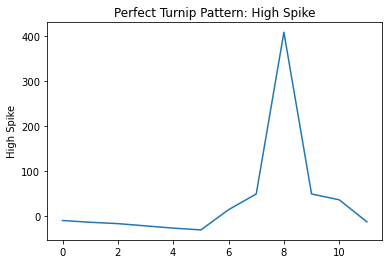

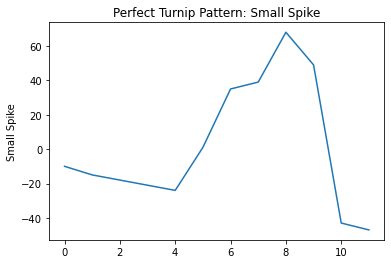

In [9]:
perfect_df, perfect_indexes = construct_graph_data(perfect_X, perfect_y)
graph_turnip_prices(perfect_df, perfect_df.index, is_perfect=True)

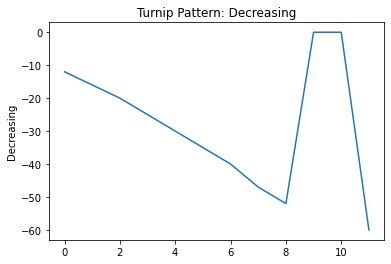

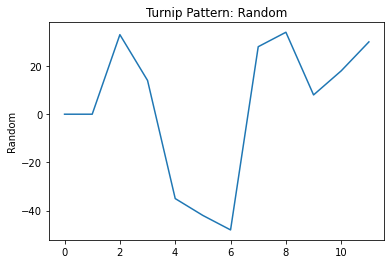

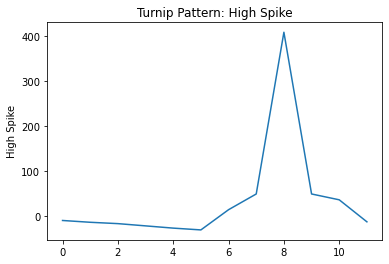

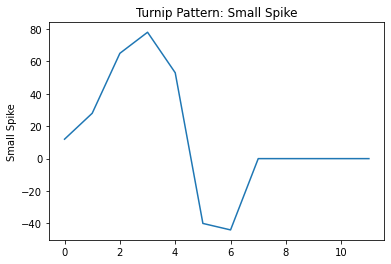

In [10]:
valid_df, valid_indexes = construct_graph_data(valid_X, valid_y)
graph_turnip_prices(valid_df, valid_df.index)

In [11]:
def figure_out_wrong_data(rows, indexes):
    df = pd.DataFrame([str(row) for row in rows])
    graphed_rows = df.iloc[indexes]
    return list(graphed_rows.index), df

In [12]:
# This was done when I had to correct some data.
bad, df = figure_out_wrong_data([row for row in populated_rows], valid_indexes)
print(bad)
bad_rows = [rows[b] for b in bad]
[str(row) for row in bad_rows]

[17, 3, 1, 0]


['Island Raftel (Mümü), W1, Purchase: 108, Curr Pattern: TurnipPattern.EMPTY, Prev Pattern: TurnipPattern.EMPTY, Prices: [98, 136, 183, 369, 162, 126, 97, 56, 45, 80, 93, 84]',
 'Island Chupiisla (Eria), W1, Purchase: 109, Curr Pattern: TurnipPattern.EMPTY, Prev Pattern: TurnipPattern.EMPTY, Prices: [128, 85, 77, 69, 149, 66, 62, 153, 124, 114, 100, 122]',
 'Island Ronron (Mercure), W1, Purchase: 103, Curr Pattern: TurnipPattern.EMPTY, Prev Pattern: TurnipPattern.EMPTY, Prices: [92, 89, 86, 82, 78, None, None, None, None, None, None, None]',
 'Island Knight (Maddox), W1, Purchase: 100, Curr Pattern: TurnipPattern.EMPTY, Prev Pattern: TurnipPattern.EMPTY, Prices: [87, 83, 79, 75, 70, 67, None, None, 299, 148, 106, 68]']

In [13]:
def graph_test_accuracy(results_filename):
    results = utility.load_results(results_filename)
    df = pd.DataFrame(results)
    df['test_accuracy'] = 1 - df['n_wrong'] / df['n_tests']
    plt.suptitle('Model Accuracy')
    plt.title(f'Min. # of Prices for Valid Data: {df["min_num_prices"][0]}')
    sns.lineplot(data=df, x='train_size', y='test_accuracy', hue='classifier')
    plt.show()

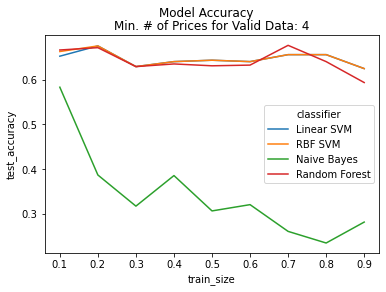

'results_20201123_161333.json'

In [14]:
results_filename = utility.get_most_recent_results()
graph_test_accuracy(results_filename)
results_filename

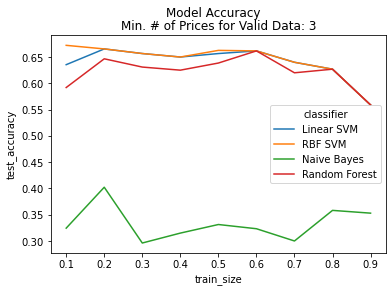

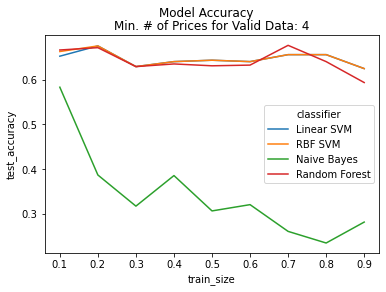

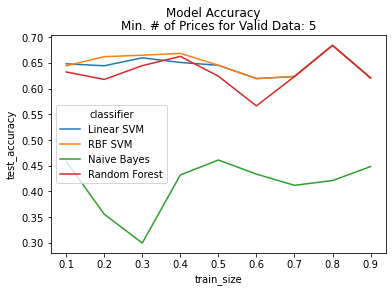

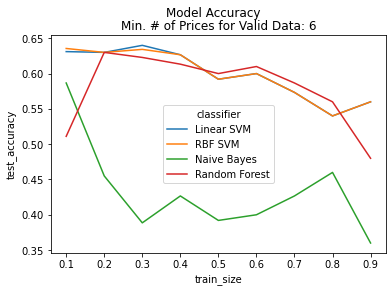

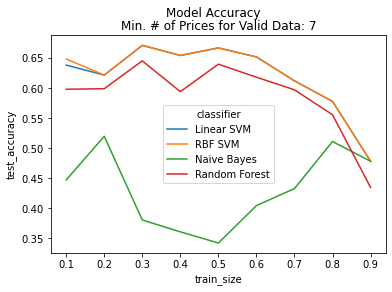

In [15]:
chosen_results = [('results_20201123_145600.json', 3), ('results_20201123_161333.json', 4), ('results_20201121_163822.json',5), ('results_20201121_155316.json', 6), ('results_20201123_152447.json', 7)]
for result_filename, min_valid_prices in chosen_results:
    graph_test_accuracy(result_filename)

In [16]:
def get_results_hierarchy(results_to_join):
    result_dfs = [pd.DataFrame(utility.load_results(result)) for result, _ in results_to_join]
    raw_df = reduce(lambda d1, d2: d1.append(d2), result_dfs)
    multi_index = raw_df.set_index(['min_num_prices', 'classifier', 'train_size']).sort_index()
    return pd.DataFrame(multi_index)

In [17]:
def plot_test_accuracies_per_min_valid_prices(results_to_join):
    result_dfs = [pd.DataFrame(utility.load_results(result)) for result, _ in results_to_join]
    df = reduce(lambda d_1, d_2: d_1.append(d_2), result_dfs)
    df['test_accuracy'] = 1 - df['n_wrong'] / df['n_tests']
    plt.title('Test Accuracies per Min # of Prices')
    sns.barplot(data=df,x='min_num_prices', y='test_accuracy', hue='classifier', estimator=np.mean)
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show()

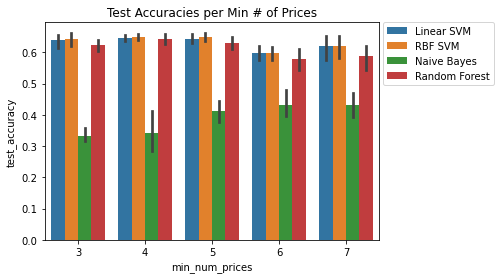

In [18]:
plot_test_accuracies_per_min_valid_prices(chosen_results)

In [19]:
def get_classifiers(results_filename):
    return list(set(pd.DataFrame(utility.load_results(results_filename))['classifier']))

In [20]:
classifiers = get_classifiers(utility.get_most_recent_results())
classifiers

['Linear SVM', 'Naive Bayes', 'RBF SVM', 'Random Forest']

In [21]:
model_filenames = [(classifier, utility.get_most_recent_model_filename(classifier)) for classifier in classifiers]
models = [(name, utility.load_model(f)) for name, f in model_filenames]
models

[('Linear SVM',
  Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                  ('linearsvc',
                   LinearSVC(C=0.125, max_iter=31622, random_state=13,
                             tol=1e-06))])),
 ('Naive Bayes', GaussianNB(var_smoothing=3.1e-11)),
 ('RBF SVM',
  Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                  ('svc',
                   SVC(C=0.125, max_iter=31622, random_state=13, tol=1e-05))])),
 ('Random Forest',
  RandomForestClassifier(ccp_alpha=0.01, max_depth=7, max_features=None,
                         n_jobs=-1, random_state=13))]

In [22]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [23]:
all_X, _, all_y = utility.get_all_data(rows)
all_X.shape, all_y.shape

((319, 12), (319, 1))

Min # of Prices to make a valid week of data: 4


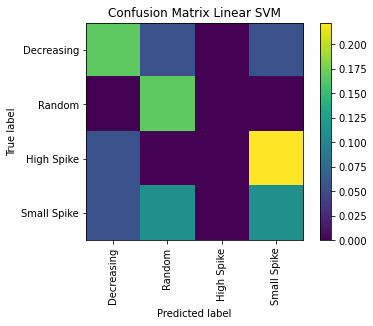

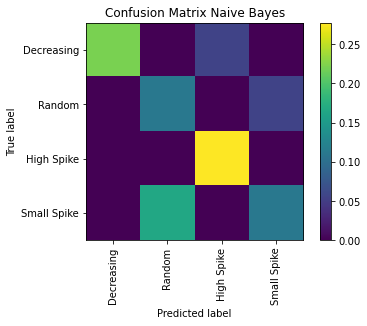

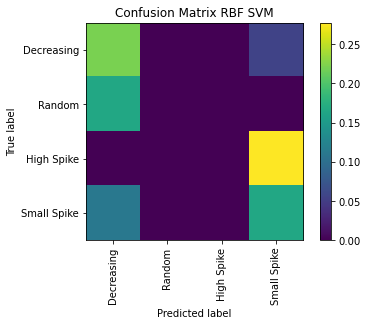

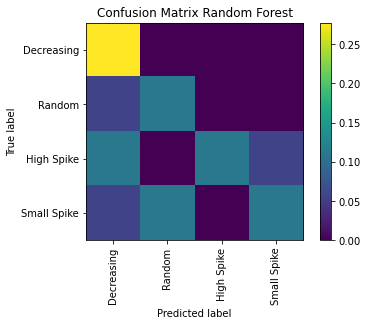

In [24]:
print(f'Min # of Prices to make a valid week of data: {MIN_NUM_PRICES}')
for name, model in models:
    train_x, test_x, train_y, test_y = train_test_split(valid_X, valid_y, train_size=.75, random_state=RANDOM_STATE)
    model.fit(train_x, train_y.reshape(-1))
    plot_confusion_matrix(model, test_x, test_y.reshape(-1), normalize='all', include_values=False, xticks_rotation='vertical', display_labels=[repr(tp) for tp in TurnipPattern][-4:])
    plt.title(f'Confusion Matrix {name}')
    plt.show()
    print()

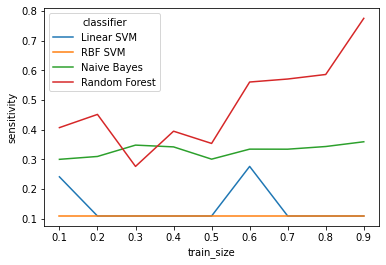

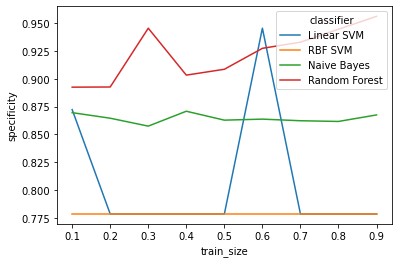

In [25]:
results_filename = [res for res, n_valid in chosen_results if n_valid == 4][0]
df = pd.DataFrame(utility.load_results(results_filename))
sns.lineplot(data=df, x='train_size', y='sensitivity', hue='classifier')
plt.show()
sns.lineplot(data=df, x='train_size', y='specificity', hue='classifier')
plt.show()